In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, RNN, LSTM, GRU, Dense, Dropout, MaxPooling1D, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from keras_tuner import Hyperband
import os
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

2025-04-26 22:18:35.488915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745680715.515019   60423 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745680715.525354   60423 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 22:18:35.643058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to /home/ardi/nltk_data...
[nltk_data]   Package stopwords is alr

True

In [2]:
import tensorflow as tf

# Enable mixed precision policy (optional, after memory growth setup)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Configure GPU memory growth to prevent OOM errors
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Common parameters
BATCH_SIZE = 64
EPOCHS = 5
EPOCHS_TUNER = 5
validation_split = 0.2

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Penjelasan Kode:
#### 1. **LSTM Layer dengan Regularisasi**
Layer LSTM digunakan untuk menangani data sekuensial. Di kode, LSTM dilengkapi dengan opsi seperti regularisasi kernel (`kernel_regularizer`) untuk mengurangi risiko overfitting. Penjelasan parameter penting:
- **`activation='tanh'`**: Fungsi aktivasi utama yang digunakan untuk memproses data.
- **`recurrent_activation='sigmoid'`**: Fungsi aktivasi untuk bagian berulang dari LSTM.
- **`use_bias=True`**: Bias ditambahkan untuk meningkatkan fleksibilitas model.
- **`dropout=0.0` dan `recurrent_dropout=0.0`**: Dropout mengurangi overfitting dengan menjadikan beberapa neuron nonaktif saat pelatihan.
- **`kernel_regularizer=l2(0.001)`**: Regularisasi kernel untuk menjaga parameter tetap kecil.

#### 2. **Bidirectional LSTM**
Bidirectional LSTM memungkinkan model untuk belajar dari konteks data sekuensial baik dari arah maju (forward) maupun mundur (backward), menangkap informasi secara lebih lengkap.

#### 3. **Layer Normalization**
Layer normalisasi stabilkan distribusi aktivasi jaringan, mempercepat pelatihan, dan meningkatkan performa model.

#### 4. **Dense Layer**
Dense layer mengubah hasil dari LSTM menjadi representasi informatif sebelum ke layer keluaran. Aktivasi `relu` digunakan untuk menangkap hubungan non-linear.

---

### Penjelasan Teori:
#### **LSTM dan Mekanisme Gate**
LSTM adalah pengembangan dari RNN yang dapat mengatasi **vanishing gradient problem**. Berikut mekanisme dasar gate pada LSTM:
1. **Forget Gate**:
   $$ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $$
   - Mengontrol informasi mana yang harus dilupakan.
2. **Input Gate**:
   $$ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $$
   $$ \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C) $$
   - Mengontrol informasi baru yang akan disimpan ke memori.
3. **Cell State Update**:
   $$ C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t $$
   - Memperbarui state sel.
4. **Output Gate**:
   $$ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) $$
   $$ h_t = o_t \cdot \text{tanh}(C_t) $$
   - Mengontrol keluaran berdasarkan state sel yang diperbarui.

#### **Bidirectional LSTM**
Bidirectional LSTM meningkatkan kinerja dengan memproses data sekuensial dalam dua arah:
- **Forward**: Dari awal hingga akhir sekuens.
- **Backward**: Dari akhir ke awal sekuens.

Dalam kode, LSTM ini diimplementasikan menggunakan:
```python
model.add(Bidirectional(LSTM(...)))

In [ ]:
# ======= Helper functions =======
def preprocess_text_data(texts, labels, max_features, max_length):
    """Tokenize and pad text data."""
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return X, y, tokenizer

def build_model_hyperband(hp, max_features, max_length):
    """Build model with hyperparameters and attention mechanism."""
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    ))
    
    # BiRNN layer
    BiRNN_units = hp.Int('BiRNN_units', min_value=64, max_value=256, step=64)

    from tensorflow.keras import regularizers
    model.add(Bidirectional(LSTM(
        units=BiRNN_units,
        activation='tanh',
        recurrent_activation='sigmoid',
        use_bias=True,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal',
        bias_initializer='zeros',
        unit_forget_bias=True,
        kernel_regularizer=regularizers.l2(0.001),
        recurrent_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        recurrent_constraint=None,
        bias_constraint=None,
        dropout=0.0,
        recurrent_dropout=0.0,
        seed=None,
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        use_cudnn='auto'
    )))

    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dropout(hp.Float('BiRNN_dropout', min_value=0.3, max_value=0.5, step=0.1)))

    # Pooling and dense layers
    model.add(Dense(BiRNN_units*2, activation="relu", 
                kernel_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.LayerNormalization())

    # Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Penjelasan Kode
Fungsi `evaluate_and_visualize` bertujuan untuk:
1. **Melatih Model**: Proses pelatihan dilakukan dengan data latih (`X_train, y_train`) dan data validasi (`X_test, y_test`) dengan metode `fit`.
2. **Evaluasi Model**: Menghitung metrik performa model seperti akurasi, presisi, recall, F1 score, AUC (Area Under Curve).
3. **Visualisasi**: Menampilkan grafik performa pelatihan, confusion matrix, dan ROC (Receiver Operating Characteristic) curve.

#### Detail Komponen:
1. **Melatih Model**:
   Fungsi `model.fit` digunakan untuk melatih model dengan parameter:
   - **`epochs`**: Jumlah iterasi penuh terhadap data latih.
   - **`batch_size`**: Jumlah sampel dalam tiap batch saat pelatihan.

2. **Evaluasi Model**:
   Metrik evaluasi yang dihitung:
   - **Akurasi**: Rasio prediksi benar terhadap total data.
   - **Presisi**: Rasio data positif yang benar terhadap total prediksi positif.
     $$ \text{Precision} = \frac{TP}{TP + FP} $$
   - **Recall**: Rasio data positif yang benar terhadap total data positif sebenarnya.
     $$ \text{Recall} = \frac{TP}{TP + FN} $$
   - **F1 Score**: Harmonik antara presisi dan recall.
     $$ \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$
   - **AUC**: Area di bawah ROC Curve, mengukur kemampuan model membedakan kelas.

3. **Visualisasi**:
   - Grafik **akurasi** dan **loss** terhadap epoch untuk melihat proses pelatihan.
   - **Confusion Matrix**: Matriks untuk mengukur kesalahan prediksi antara kelas aktual dan prediksi.
     Contoh struktur:
     | Actual \ Predicted | Not Positive | Positive |
     |---------------------|--------------|----------|
     | **Not Positive**    | TN           | FP       |
     | **Positive**        | FN           | TP       |
   - **ROC Curve**: Grafik trade-off antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**.
     $$ \text{TPR} = \frac{TP}{TP + FN} $$
     $$ \text{FPR} = \frac{FP}{FP + TN} $$

---

### Persamaan Matematika yang Digunakan:
1. **Akurasi**:
   $$ \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} $$

2. **Presisi**:
   $$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

3. **Recall**:
   $$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

4. **F1 Score**:
   $$ \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$

5. **AUC (Area Under Curve)**:
   Nilai ini dihitung berdasarkan integral dari ROC Curve:
   $$ \text{AUC} = \int_0^1 TPR \, dFPR $$

6. **ROC Curve**:
   - **True Positive Rate (TPR)**:
     $$ TPR = \frac{\text{TP}}{\text{TP} + \text{FN}} $$
   - **False Positive Rate (FPR)**:
     $$ FPR = \frac{\text{FP}}{\text{FP} + \text{TN}} $$

---

In [4]:
def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name):
    """Train, evaluate and visualize the model."""
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test)
    )
    
    # ======= Evaluate the model =======
    # Get predictions
    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # ======= Visualization =======
    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{dataset_name} - Accuracy vs Epochs')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{dataset_name} - Loss vs Epochs')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    class_labels = ['Not Positive', 'Positive']
    if dataset_name == "DeteksiSarkasme":
        class_labels = ['Not Sarcastic', 'Sarcastic']
        
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} - Confusion Matrix')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{dataset_name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'history': history.history
    }

# Penjelasan Kode: `run_experiment`

## Fungsi
Fungsi `run_experiment` adalah bagian penting dari kode pembelajaran mesin. Fungsinya adalah:
1. **Persiapan Data:** Memanggil `prepare_data_fn` untuk membagi data menjadi data pelatihan dan pengujian.
2. **Tuning Hyperparameter:** Menggunakan metode Hyperband untuk menemukan hyperparameter terbaik.
3. **Pembuatan Model:** Membuat model berdasarkan hyperparameter terbaik.
4. **Evaluasi dan Visualisasi:** Mengevaluasi model terbaik dan menampilkan hasilnya.

---

## Persamaan Matematika yang Relevan

### 1. **Akurasi Validasi**
Hyperband mengoptimalkan akurasi validasi menggunakan rumus:
$$
\text{val\_accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$
di mana:
- $ TP $: True Positives
- $ TN $: True Negatives
- $ FP $: False Positives
- $ FN $: False Negatives

### 2. **Akurasi Evaluasi**
Rumus akurasi model untuk data uji:
$$
\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Data}}
$$

### 3. **Split Data untuk Validasi**
Data dibagi menjadi pelatihan dan validasi menggunakan `validation_split`:
$$
\text{validation\_split} = \frac{\text{Jumlah Data Validasi}}{\text{Jumlah Data Latih}}
$$

### 4. **Faktor Hyperband**
Hyperband mengontrol alokasi sumber daya menggunakan faktor $ f $:

$$f = 3$$


---

## Komponen Utama Kode
1. **Hyperband:** Digunakan untuk mencari hyperparameter terbaik secara otomatis.
2. **`build_model_hyperband`:** Fungsi untuk membangun model berdasarkan konfigurasi hyperparameter.
3. **`evaluate_and_visualize`:** Mengevaluasi model dan membuat visualisasi hasil.

---

In [5]:
# ======= Main Execution =======
def run_experiment(dataset_name, prepare_data_fn, max_features, max_length):
    print(f"\n{'='*20} Running {dataset_name} Experiment {'='*20}")
    
    # Prepare data
    X_train, y_train, X_test, y_test = prepare_data_fn()
    
    # Define hyperparameter tuner
    tuner = Hyperband(
        lambda hp: build_model_hyperband(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=f'tuner_{dataset_name.lower().replace(" ", "_")}',
        project_name=dataset_name.lower().replace(" ", "_")
    )
    
    # Search for best hyperparameters
    print(f"\nTuning model for {dataset_name}...")
    tuner.search(
        X_train, y_train,
        epochs=EPOCHS_TUNER,
        batch_size=BATCH_SIZE,
        validation_split=validation_split
    )
    
    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\nBest Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")
    
    # Build model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hps)
    
    # Train, evaluate and visualize the best model
    results = evaluate_and_visualize(
        best_model , X_train, y_train, X_test, y_test, 
        dataset_name
    )
    
    return best_model , results

results = {}

# IMDb Dataset

In [6]:
MAX_FEATURES_IMDB = 30000
MAX_LENGTH_IMDB = 300

# ======= IMDB Dataset Processing =======
def process_imdb_dataset():
    print("\n=== Processing IMDB Dataset ===")
    # Load IMDB dataset
    (X_train_raw, y_train), (X_test_raw, y_test) = imdb.load_data(num_words=MAX_FEATURES_IMDB)
    
    # Convert indices back to words for better understanding
    word_index = imdb.get_word_index()
    # Reverse the word index to get words
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    
    # Convert sequences back to text
    def sequence_to_text(sequence):
        # Note: 0, 1, and 2 are reserved indices
        return ' '.join([reverse_word_index.get(i - 3, '?') for i in sequence if i > 3])
    
    X_train = pad_sequences(X_train_raw, maxlen=MAX_LENGTH_IMDB)
    X_test = pad_sequences(X_test_raw, maxlen=MAX_LENGTH_IMDB)
    
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    
    return X_train, y_train, X_test, y_test

Trial 10 Complete [00h 02m 24s]
val_accuracy: 0.8691999912261963

Best val_accuracy So Far: 0.8858000040054321
Total elapsed time: 00h 16m 11s

Best Hyperparameters:
embedding_dim: 128
BiRNN_units: 64
BiRNN_dropout: 0.4
learning_rate: 0.0006017119248037565
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 49s 114ms/step - accuracy: 0.6726 - loss: 0.9085 - val_accuracy: 0.8680 - val_loss: 0.5149
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.9054 - loss: 0.3984 - val_accuracy: 0.8373 - val_loss: 0.5449
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 111ms/step - accuracy: 0.9231 - loss: 0.3249 - val_accuracy: 0.8249 - val_loss: 0.4945
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.9546 - loss: 0.2251 - val_accuracy: 0.8254 - val_loss: 0.5556
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.9722 - loss: 0.1495 - val_accuracy: 0.8020 - val_loss: 0.5762
782/782 ━━━━━━━━━━━━━━

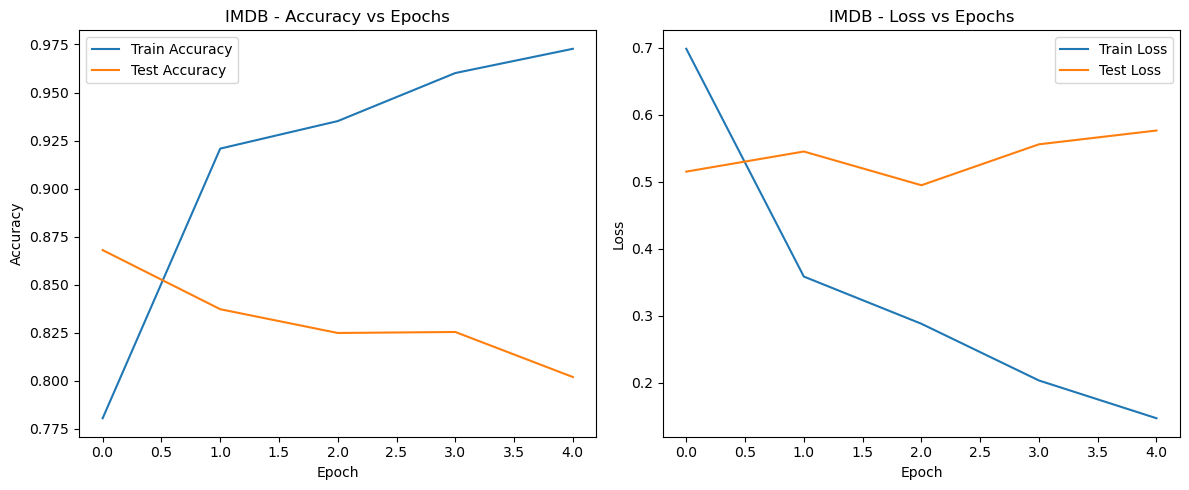

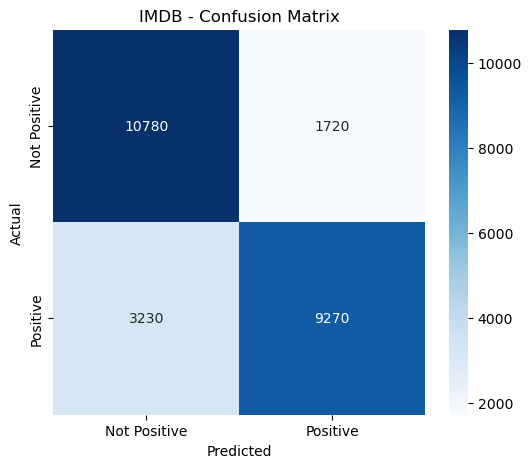

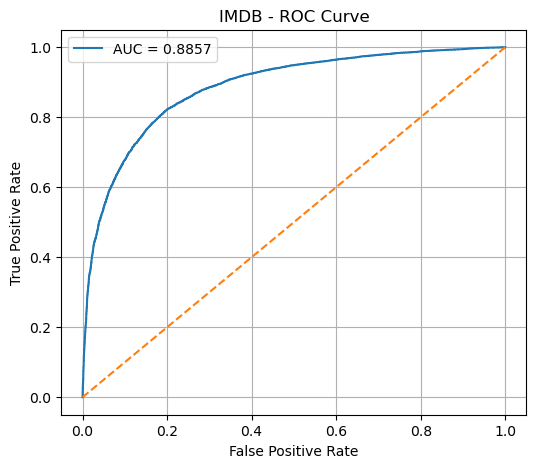

In [7]:
# IMDB Dataset Best Hyperparameter with Keras-Tuner
best_model_imdb, results_imdb = run_experiment("IMDB", process_imdb_dataset, MAX_FEATURES_IMDB, MAX_LENGTH_IMDB)
results["IMDB"] = results_imdb

# ReviewTokoBaju Dataset

In [8]:
MAX_FEATURES_ReviewTokoBaju = 10000
MAX_LENGTH_ReviewTokoBaju = 100

# ======= ReviewTokoBaju Dataset Processing =======
# Build vocabulary from the dataset
def build_vocab(texts, max_words=MAX_FEATURES_ReviewTokoBaju):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    # Sort words by frequency
    vocab = {word: idx+1 for idx, (word, _) in 
             enumerate(word_counts.most_common(max_words-1))}
    # Add padding token
    vocab['<PAD>'] = 0
    return vocab

def process_ReviewTokoBaju_dataset():
    print("\n=== Processing ReviewTokoBaju Dataset ===")
    
    # Load dataset
    reviewtokobaju_file = "/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 7/IMDb, ReviewTokoBaju, DeteksiSarkasme/ReviewTokoBaju.csv"
    df = pd.read_csv(reviewtokobaju_file)

    df=df.drop_duplicates()

    df.drop([ "Clothing ID","Age","Title","Positive Feedback Count","Division Name","Department Name","Class Name"], axis = 1, inplace = True)
    
    # Preprocess
    df = df[['Review Text', 'Rating']].dropna()
    df['label'] = (df['Rating'] >= 4).astype(int)  # Ratings 4 and 5 are positive
    
    # Text cleaning and processing
    def clean_text(text):
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
            text = re.sub(r'\d+', '', text)  # Remove numbers
            stop_words = set(stopwords.words('english'))
            word_tokens = word_tokenize(text)
            text = ' '.join([w for w in word_tokens if w not in stop_words])  # Remove stopwords
            return text
        else:
            return ""  # Return empty string for NaN values
    
    # Apply text cleaning
    df['processed_review'] = df['Review Text'].apply(clean_text)
    
    # Build vocabulary
    vocabulary = build_vocab(df['processed_review'].tolist(), max_words=MAX_FEATURES_ReviewTokoBaju)
    vocab_size = len(vocabulary)
    print(f"Vocabulary size: {vocab_size}")
    
    # Convert texts to sequences
    def text_to_sequence(text, vocab, maxlen):
        words = text.split()
        sequence = [vocab.get(word, 0) for word in words]  # Use 0 for OOV words
        if len(sequence) > maxlen:
            sequence = sequence[:maxlen]
        else:
            sequence = sequence + [0] * (maxlen - len(sequence))  # Pad sequences
        return sequence
    
    df['sequence'] = df['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, MAX_LENGTH_ReviewTokoBaju))
    
    # Split data into training and testing sets
    X = np.array(df['sequence'].tolist())
    y = np.array(df['label'].tolist())
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    
    return X_train, y_train, X_test, y_test


==================== Running ReviewTokoBaju Experiment ====================

=== Processing ReviewTokoBaju Dataset ===
Vocabulary size: 10000
Training samples: 18112
Testing samples: 4529
Reloading Tuner from tuner_reviewtokobaju/reviewtokobaju/tuner0.json

Tuning model for ReviewTokoBaju...

Best Hyperparameters:
embedding_dim: 128
BiRNN_units: 64
BiRNN_dropout: 0.3
learning_rate: 0.00503822561891769
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8014 - loss: 0.6444 - val_accuracy: 0.8684 - val_loss: 0.3726
Epoch 2/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8952 - loss: 0.3112 - val_accuracy: 0.8496 - val_loss: 0.3724
Epoch 3/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9281 - loss: 0.2302 - val_accuracy: 0.8585 - val_loss: 0.3697
Epoch 4/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9341 - loss: 0.2205 - val_accuracy: 0.8470 - val_loss: 0.3957
Epoch 5

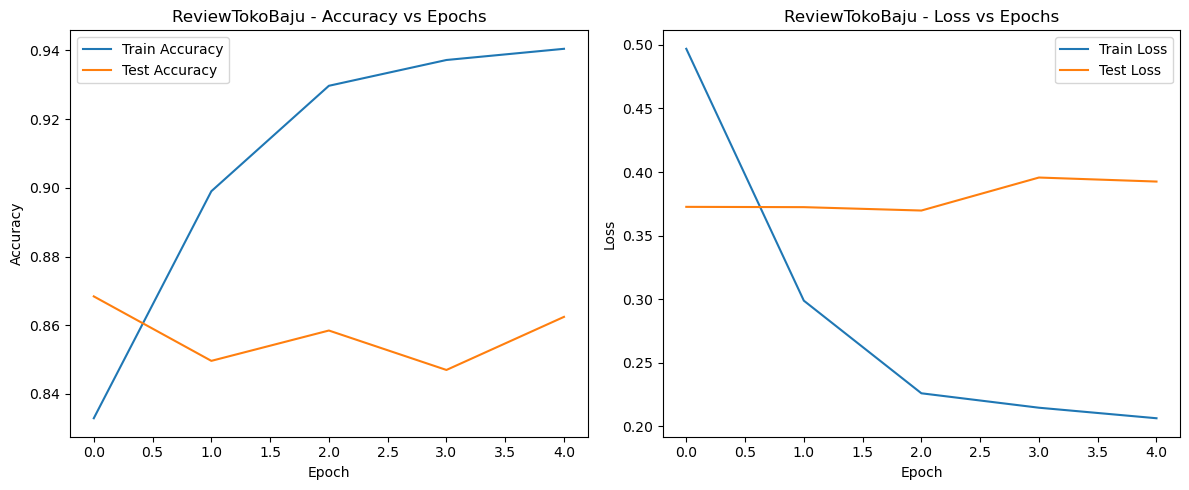

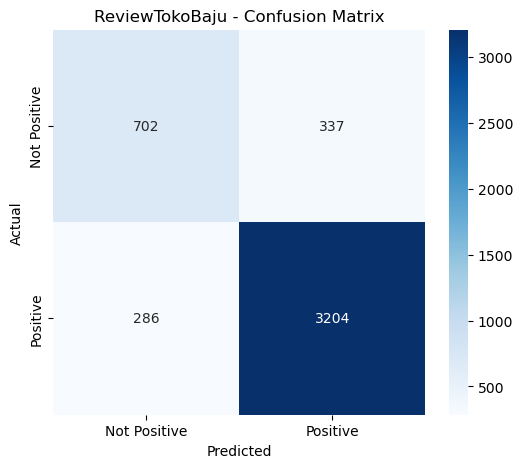

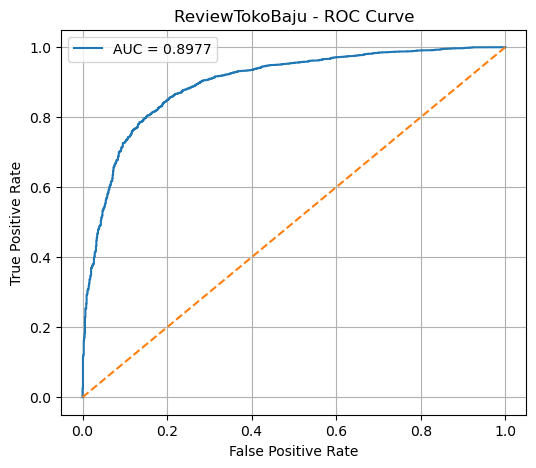

In [9]:
# ReviewTokoBaju Dataset Best Hyperparameter with Keras-Tuner
best_model_ReviewTokoBaju, results_ReviewTokoBaju = run_experiment("ReviewTokoBaju", process_ReviewTokoBaju_dataset, MAX_FEATURES_ReviewTokoBaju, MAX_LENGTH_ReviewTokoBaju)
results["ReviewTokoBaju"] = results_ReviewTokoBaju

# DeteksiSarkasme Dataset

In [10]:
MAX_FEATURES_DeteksiSarkasme = 10000
MAX_LENGTH_DeteksiSarkasme = 50

# ======= DeteksiSarkasme Dataset Processing =======
def process_DeteksiSarkasme_dataset():
    print("\n=== Processing DeteksiSarkasme Dataset ===")
    
    # Load dataset
    deteksisarkasme_file = "/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 7/IMDb, ReviewTokoBaju, DeteksiSarkasme/DeteksiSarkasme.json"
    
    with open(deteksisarkasme_file, 'r') as f:
        data = [json.loads(line) for line in f]
    
    df = pd.DataFrame(data)

    df=df.drop_duplicates()
    
    # Preprocessing function
    import string
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
        return text
    
    # Apply preprocessing to headlines
    df['processed_headline'] = df['headline'].apply(preprocess_text)
    
    # Tokenize and pad sequences
    tokenizer = Tokenizer(num_words=MAX_FEATURES_DeteksiSarkasme, oov_token='<UNK>')
    tokenizer.fit_on_texts(df['processed_headline'])
    sequences = tokenizer.texts_to_sequences(df['processed_headline'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH_DeteksiSarkasme, padding='post')
    
    # Get vocabulary size (add 1 for the 0 padding token)
    vocab_size = min(MAX_FEATURES_DeteksiSarkasme, len(tokenizer.word_index) + 1)
    
    X = padded_sequences
    y = np.array(df['is_sarcastic'])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    
    return X_train, y_train, X_test, y_test

Trial 10 Complete [00h 01m 09s]
val_accuracy: 0.8277959823608398

Best val_accuracy So Far: 0.855404794216156
Total elapsed time: 00h 07m 34s

Best Hyperparameters:
embedding_dim: 192
BiRNN_units: 192
BiRNN_dropout: 0.4
learning_rate: 0.00033139486400914574
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.6964 - loss: 1.3436 - val_accuracy: 0.8469 - val_loss: 0.7656
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.8924 - loss: 0.6490 - val_accuracy: 0.8532 - val_loss: 0.6940
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9375 - loss: 0.4598 - val_accuracy: 0.8390 - val_loss: 0.7607
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9606 - loss: 0.3387 - val_accuracy: 0.8343 - val_loss: 0.7736
Epoch 5/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9684 - loss: 0.2654 - val_accuracy: 0.8315 - val_loss: 0.7483
167/1

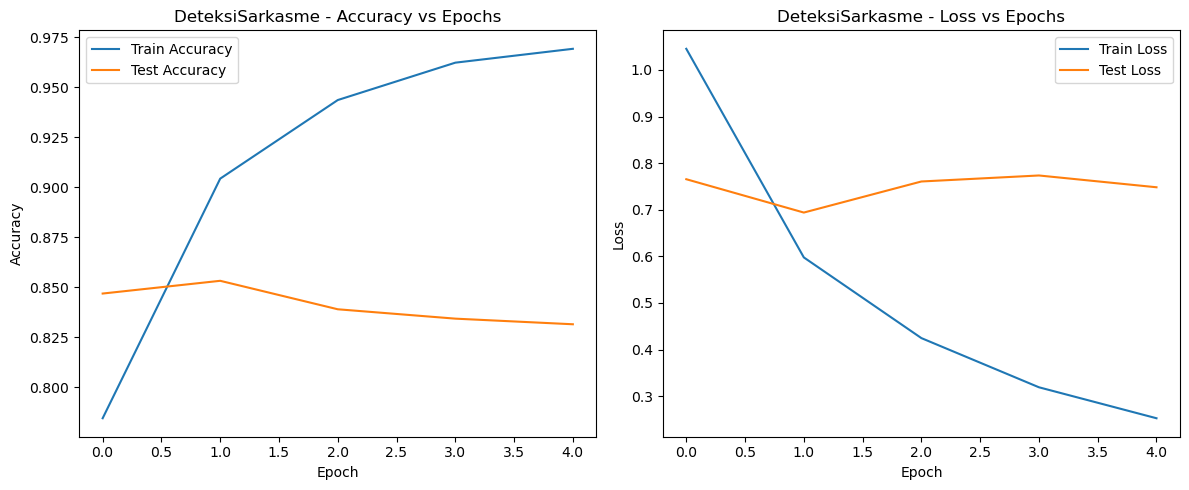

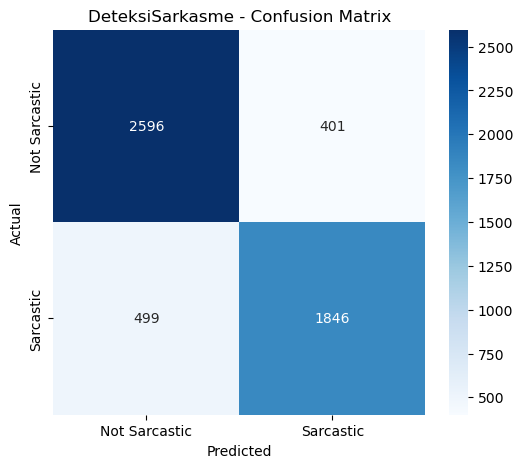

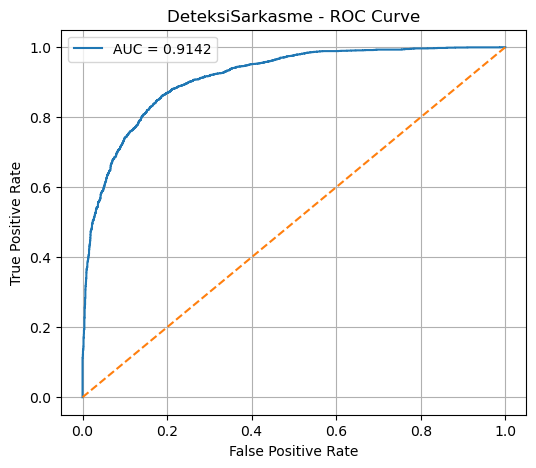

In [11]:
# DeteksiSarkasme Dataset Best Hyperparameter with Keras-Tuner
best_model_DeteksiSarkasme, results_DeteksiSarkasme = run_experiment("DeteksiSarkasme", process_DeteksiSarkasme_dataset, MAX_FEATURES_DeteksiSarkasme, MAX_LENGTH_DeteksiSarkasme)
results["DeteksiSarkasme"] = results_DeteksiSarkasme

# Komparasi Hasil



===== RESULTS COMPARISON =====
               IMDB  ReviewTokoBaju  DeteksiSarkasme
accuracy   0.802000        0.862442         0.831524
precision  0.843494        0.904829         0.821540
recall     0.741600        0.918052         0.787207
f1         0.789272        0.911392         0.804007
auc        0.885677        0.897711         0.914160


<Figure size 1200x600 with 0 Axes>

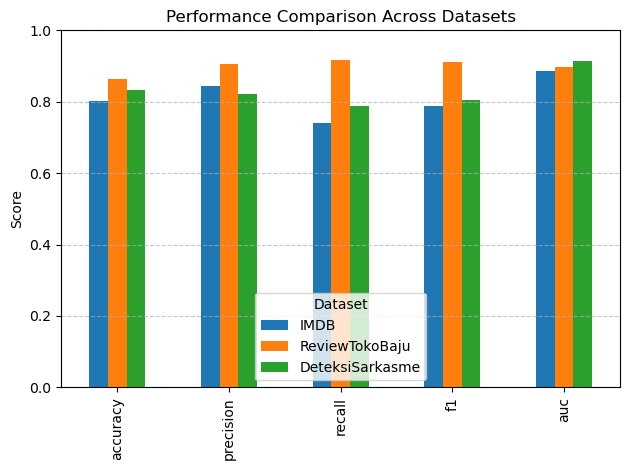

In [12]:
# Compare results
print("\n\n===== RESULTS COMPARISON =====")
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
comparison_df = pd.DataFrame({
    dataset: [results[dataset][metric] for metric in metrics]
    for dataset in results
}, index=metrics)

print(comparison_df)

# Visualize comparison
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar')
plt.title('Performance Comparison Across Datasets')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()